# 02 - Data from the Web

In [1]:
import pandas as pd
import numpy as np
from requests import get
from bs4 import BeautifulSoup as bs
import json
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.import seaborn as sns

## Useful functions

In [75]:
def clean_number(n):
    return int(''.join(filter(lambda c: c.isdigit(), n)))

def select_or_zero(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_number(selection[0].text)

def select_url(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_url(selection[0]['href'])

def normalize_name(name):
    name = str(name)
    name = re.sub('\(.*\)','', name)
    name = re.sub('^The','', name)
    name = re.sub('^É','E', name)
    name = name.replace('–', '-')
    return name.title().strip()

def map_name(name):
    if name == 'Ucl':
        return 'University College London'
    if name == 'Eth Zurich - Swiss Federal Institute Of Technology':
        return 'Eth Zurich - Swiss Federal Institute Of Technology Zurich'
    if name == "King’S College London" or name == "King'S College London":
        return "King's College London"
    if name == 'University Of Freiburg':
        return 'Albert-Ludwigs-Universitaet Freiburg'
    if name == 'Autonomous University Of Barcelona':
        return 'Universitat Autònoma De Barcelona'
    if name == 'Free University Of Berlin':
        return 'Freie Universitaet Berlin'
    if name == 'Heidelberg University':
        return 'Ruprecht-Karls-Universität Heidelberg'
    if name == 'Humboldt University Of Berlin':
        return 'Humboldt-Universität Zu Berlin'
    if name == 'Karlsruhe Institute Of Technology':
        return 'Kit, Karlsruhe Institute Of Technology'
    if name == 'Korea Advanced Institute Of Science And Technology':
        return 'Kaist - Korea Advanced Institute Of Science & Technology'
    if name == 'Pierre And Marie Curie University':
        return 'Université Pierre Et Marie Curie'
    if name == 'Scuola Superiore Sant’Anna':
        return "Scuola Superiore Sant'Anna Pisa Di Studi Universitari E Di Perfezionamento"
    if name == 'Technical University Of Berlin':
        return 'Technische Universität Berlin'
    if name == 'Trinity College Dublin, The University Of Dublin':
        return 'Trinity College Dublin'   
    if name == 'University Of Montreal':
        return 'Université De Montréal'
    if name ==  'University Of North Carolina, Chapel Hill':
        return 'University Of North Carolina At Chapel Hill'
    if name == 'University Of Tübingen':
        return 'Eberhard Karls Universität Tübingen'
    if name == 'Wageningen University & Research':
        return 'Wageningen University'
    if name == 'Washington University In St Louis':
        return 'Washington University In St. Louis'
    if name == 'Lmu Munich':
        return 'Ludwig-Maximilians-Universität München'
    return name

## Question 1:  TopUniversities website

By inspecting the top universities website with postman interceptor, we noticed that the actual ranking is loaded from a json file. The json contains the university name, its rank, its country. We can easily extract the first 200 universities from this json.

We are still missing some data at this point, such as the total number of faculty members, the numbe rof international faculty members, the total number of students and the number of international students.

We can only extract these information from the university description page, also given in the json. What we did is load the description page and then, using css selector, we selected the correct div containing the value and extracted it.

In [108]:
def get_stats(directory):
    res = get('https://www.topuniversities.com'+directory)
    soup = bs(res.text, "lxml")
    faculty_total = select_or_zero(soup, '.total .text .number')
    faculty_inter = select_or_zero(soup, '.inter .text .number')
    student_total = select_or_zero(soup, '.student .number')
    student_inter = select_or_zero(soup, '.inter .progress-bar-info .number')
    return faculty_total, faculty_inter, student_total, student_inter

def prepare_uni_data_tu(uni):
    uni_infos = dict()
    uni_infos['Name'] = map_name(normalize_name(uni['title']))
    uni_infos['Rank Top Universities'] = clean_number(uni['rank_display'])
    uni_infos['Country'] = uni['country'].strip()
    uni_infos['Region'] = uni['region'].strip()
    uni_infos['Total faculty members'], \
    uni_infos['International faculty members'], \
    uni_infos['Total students'], \
    uni_infos['International students'] = get_stats(uni['url'])
    return uni_infos

res = get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508338164061', 'html')
json_ranking_tu = json.loads(res.text)['data']
json_ranking_tu_top = sorted(json_ranking_tu, key=lambda k: clean_number(k['rank_display']))[:200]
df_tu = pd.DataFrame(list(map(prepare_uni_data_tu,json_ranking_tu_top)))

In [77]:
# df_tu.to_pickle('df_tu.xz')
df_tu = pd.read_pickle('df_tu.xz')

Here we define some functions that we'll use for the analysis. we commented them to describe their working.

Note that these functions will be heavily used afterwards, however the number of arguments can sometimes generate a high cognitive load, thus we will often call the function with keyword arguments, even if that is not necessary, to ease the reader's mind.

In [106]:
# this function sorts a dataframe by creating a new column named column_name, 
# which consists of the ratio between the values contained in column_nominator
# and those in column_denominator.
def sorted_ratio(df, column_nominator, column_denominator, column_name):
    df_temp = df.copy()
    df_temp[column_name] = df_temp[column_nominator]/df_temp[column_denominator]
    df_sorted = df_temp.sort_values(by=[column_name], ascending=False)
    return df_sorted

# this function groups a dataframe by a column named grouping_column, then aggregates the grouped_by dataframe 
# by summing the fields.
def group(df, grouping_column):
    df_temp = df.copy()
    df_grouped = df_temp.groupby([grouping_column])
    df_aggregated = df_grouped.mean()
    return df_aggregated

# this function plot the column named x on the x-axis and the column named y on the y-axis. 
# x- and y-label are the axys's labels.
def plot(df, x, y, xlabel, ylabel):
    barchart = df.plot.bar(x=x, y=y)
    barchart.set_xlabel(xlabel)
    barchart.set_ylabel(ylabel)
    plt.show()

#plots only the first 10 rows of a dataframe
def reduced_plot(df, x, y, xlabel, ylabel):
    reduced_index = np.arange(10)
    reduced_df = df.take(reduced_index)
    plot(reduced_df, x, y, xlabel, ylabel)

Here I define some variables which I will use to index the dataframe.


In [86]:
#column index
name = 'Name'
total_faculty_members = 'Total faculty members'
total_students = 'Total students'
international_students = 'International students'
faculty_members_students_ratio = 'Ratio faculty members/students'
international_students_ratio = 'Ratio international students'
country = 'Country'
region = 'Region'
students_staff_ratio ='Student/Staff Ratio'
pc_international_students = '% of International Students'
number_international_students = 'Number of International Students'
number_students = 'Number of Students'
#x- and y- labels
university_name = 'University name'

We compute the faculty members/student ratio and the international student ratio.

In [111]:
df_tu[faculty_members_students_ratio] = df_tu[total_faculty_members]/df_tu[total_students]
df_tu[international_students_ratio] = df_tu[international_students]/df_tu[total_students]

## Question a)
We sort the dataframe, compute the ratio as required and plot the 10 universities with the higher faculty members/student ratio. It can be noted that all of the 10 universities belong to the english-speaking world - either American or English - so this could speak of an anglophone university model that employs a consistent number of faculty members.

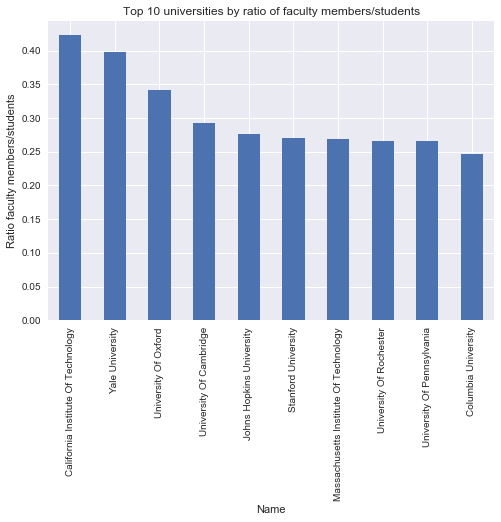

In [123]:
barplot = df_tu.sort_values(by=faculty_members_students_ratio, ascending=False).iloc[:10]\
    .plot.bar(x=name, y=faculty_members_students_ratio, legend=False);
barplot.set_title('Top 10 universities by ratio of faculty members/students')
barplot.set_xlabel(name)
barplot.set_ylabel(faculty_members_students_ratio);

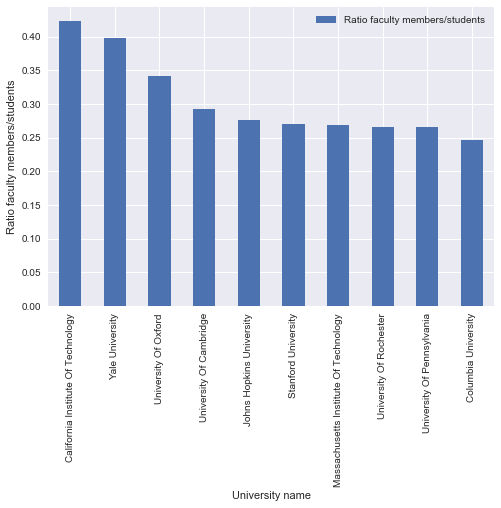

In [112]:
df_tu_QA = sorted_ratio(df_tu, column_nominator=total_faculty_members, column_denominator=total_students,\
                        column_name=faculty_members_students_ratio)
reduced_plot(df_tu_QA, x=name, y=faculty_members_students_ratio,\
             xlabel=university_name, ylabel=faculty_members_students_ratio)

## Question b)
I sort the dataframe, compute the ratio as required and plot the 10 universities with the higher internationl students/total students ratio. It can be noted that 7 out of 10 universities are European, and 4 of these 7 are based in London. It's also interesting to notice that EPFL is second in this ranking, which means we are part of a very international campus.

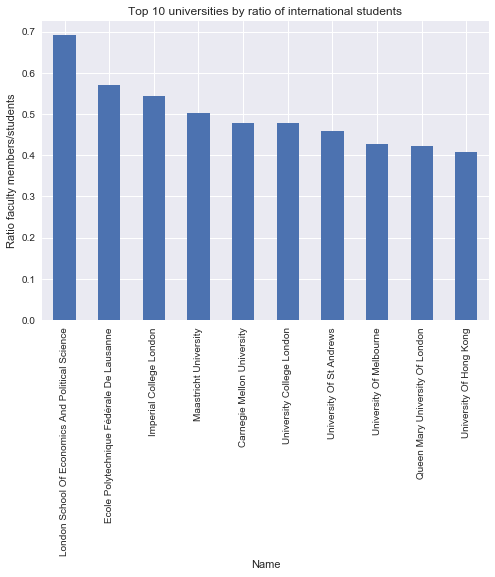

In [124]:
barplot = df_tu.sort_values(by=international_students_ratio, ascending=False).iloc[:10]\
    .plot.bar(x=name, y=international_students_ratio, legend=False);
barplot.set_title('Top 10 universities by ratio of international students')
barplot.set_xlabel(name)
barplot.set_ylabel(faculty_members_students_ratio);

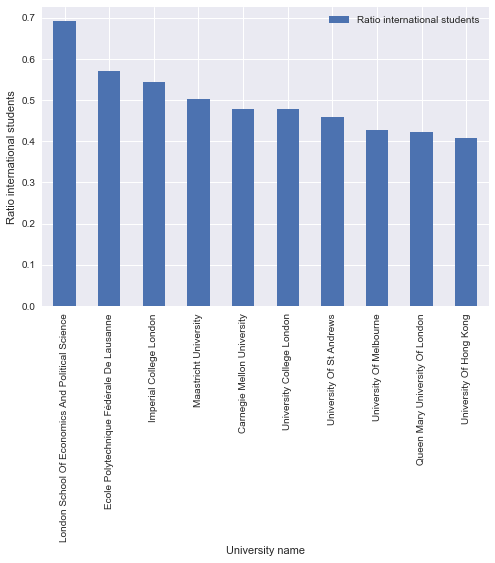

In [88]:
df_tu_QB = sorted_ratio(df_tu, column_nominator=international_students, column_denominator=total_students,\
                        column_name=international_students_ratio)
reduced_plot(df_tu_QB, x=name, y=international_students_ratio,\
             xlabel=university_name, ylabel=international_students_ratio)

## Question c)
### Faculty members and students ratio with country aggregation

What we did here is grouping the dataframe by country, then aggregating it by using the mean operator, thus obtaining a "representative university" for each country.
The results here are pretty different if compared to question a) without aggregation: UK is at the 9th place while US is at the 13th place here, while the previous question highlighted the fact that the 10 university with the highest faculty members/students ratio were American or English.
This may be explained by the fact that those 10 university are not representative of their country standard faculty members/students ratio: they're probably exceptions due to being extremely renowned. It is likely that this ratio is higher and more constant in country that ranked high like Russia.

#### Alternative
What we did here is grouping the dataframe by country, then computed the mean ratio.

The results here are pretty different if compared to question a) without aggregation: UK is at the 11th place while US is at the 7th place here, while the previous question highlighted the fact that the 10 university with the highest faculty members/students ratio were American or English.

This may be explained by the fact that those 10 university are not representative of their country standard faculty members/students ratio: they're probably exceptions due to being extremely renowned. It is likely that this ratio is higher and more constant in country that ranked high like Russia, at least for the top 200.

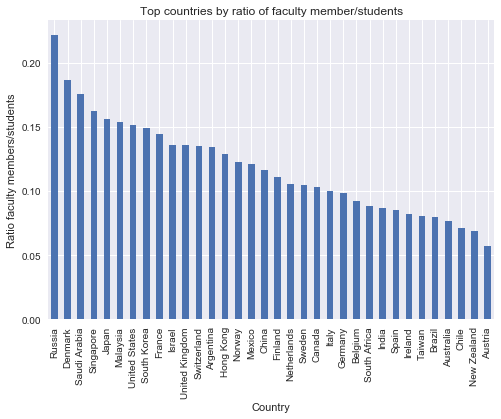

In [139]:
barplot = df_tu.groupby(country).mean().sort_values(faculty_members_students_ratio, ascending=False)\
    .plot.bar(y=faculty_members_students_ratio, legend=False)
barplot.set_title('Top countries by ratio of faculty member/students')
barplot.set_xlabel(country)
barplot.set_ylabel(faculty_members_students_ratio);

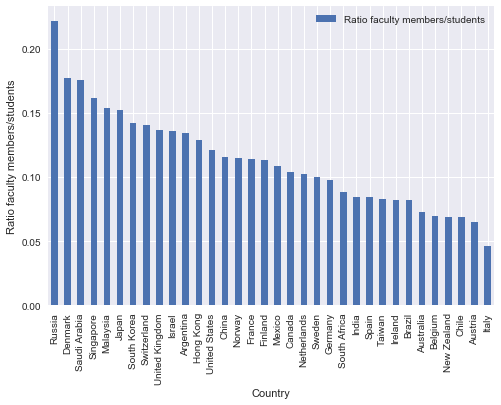

In [107]:
df_tu_country = group(df_tu, country)
df_tu_QAC = sorted_ratio(df_tu_country, total_faculty_members, total_students, faculty_members_students_ratio).reset_index()
plot(df_tu_QAC, country, faculty_members_students_ratio, country, faculty_members_students_ratio)

### International students ratio with country aggregation

What we did here is grouping the dataframe by country, then computed the mean ratio.

The results here are pretty coherent with the ones obtained without aggregating. We saw that 4 of the 10 university with higher international students were from London, and we can see that the UK is indeed at second place in the country ranking. Melbourne University and Honk Kong University were also in the ranking, and coherently enough Australia and Honk Kong are at first and third place. the presence of EPFL in the non-aggregated ranking is supported by Switzerland's 5th place in the aggregated ranking.

#### Alternative

What we did here is grouping the dataframe by country, then aggregating it by using the mean operator, thus obtaining a "representative university" for each country.

The results here are pretty coherent with the ones obtained without aggregating. We saw that 4 of the 10 university with higher international students were from London, and we can see that the UK is indeed at the first place in the country ranking. Melbourne University and Honk Kong University were also in the ranking, and coherently enough Australia and Honk Kong are at second and fourth place. the presence of EPFL in the non-aggregated ranking is supported by Switzerland's 2nd place in the aggregated ranking. This general coherence could mean that the ratio in all the top ranking universities of these country is similar, either because of fame either because of political will.

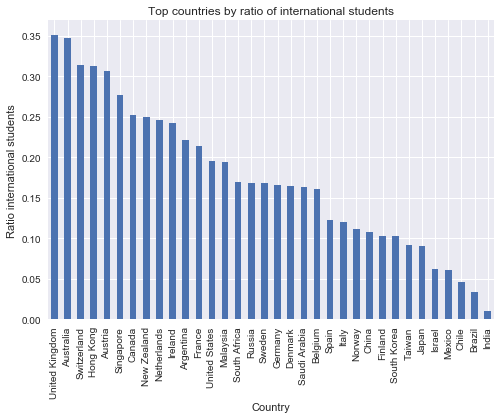

In [142]:
barplot = df_tu.groupby(country).mean().sort_values(international_students_ratio, ascending=False)\
    .plot.bar(y=international_students_ratio, legend=False)
barplot.set_title('Top countries by ratio of international students')
barplot.set_xlabel(country)
barplot.set_ylabel(international_students_ratio);

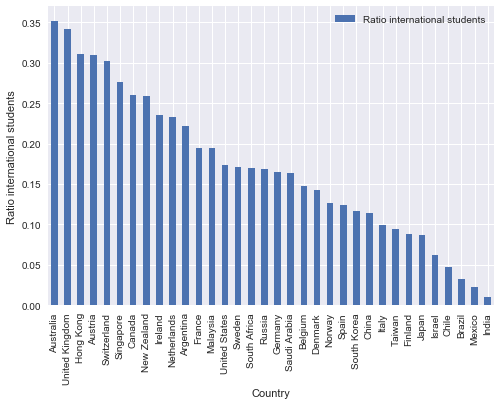

In [132]:
df_tu_QBC = sorted_ratio(df_tu_country, international_students, total_students, international_students_ratio).reset_index()
plot(df_tu_QBC, country, international_students_ratio, country, international_students_ratio)

## Question d)
### Faculty members and students ratio with region aggregation

What we did here is grouping the dataframe by region, then aggregating it by using the mean operator, thus obtaining a "representative university" for each region.

We see Asia at first place, which could be explained if we look at the country-aggregated ranking, which sees Singapore, Malaysia, Japan and South Korea in the 4th-tth places. Unexpectedly North America is second place, even if US ranked 13th in the country ranking. This is hard to explain. Europe 3rd place is backed by Russia first place in the previous ranking.

#### Alternative
What we did here is grouping the dataframe by region, then computed the mean for each region.

Unexpectedly North America is first place, even if US and Canada were not in the top places of the country ranking, this could be explained because of the disparities amongst region, meaning that even if some countries of the region scored very well, on average most of the countries scored more poorly. Also, the North America region has only two countries, which scored not so badly. Oceania which also has only two countries in the ranking is last because the two countries were also last in the above ranking.

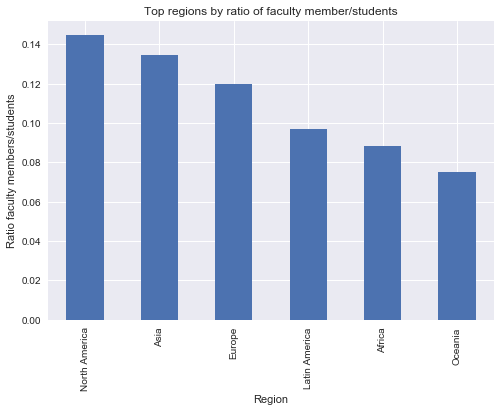

In [145]:
barplot = df_tu.groupby(region).mean().sort_values(faculty_members_students_ratio, ascending=False)\
    .plot.bar(y=faculty_members_students_ratio, legend=False)
barplot.set_title('Top regions by ratio of faculty member/students')
barplot.set_xlabel(region)
barplot.set_ylabel(faculty_members_students_ratio);

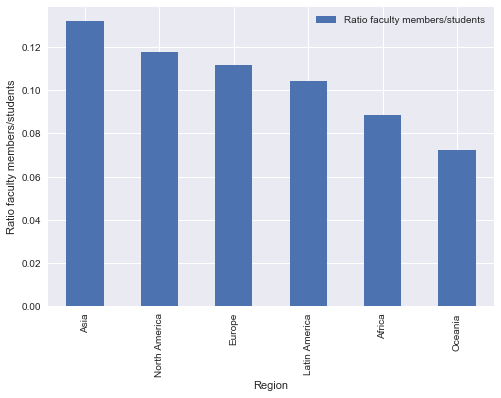

In [89]:
df_tu_region = group(df_tu, region)
df_tu_QAD = sorted_ratio(df_tu_region, total_faculty_members, total_students, faculty_members_students_ratio).reset_index()
plot(df_tu_QAD, region, faculty_members_students_ratio, region, faculty_members_students_ratio)

### International students ratio with region aggregation

What we did here is grouping the dataframe by region, then aggregating it by using the mean operator, thus obtaining a "representative university" for each region.
The result are coherent with the previous one: Australia was first in the country-aggregated ranking and Oceania is first in the region-aggregated ranking. UK was second and Europe is second. Still hard to justify North America's position.

#### Alternative
What we did here is grouping the dataframe by region, then compute the mean ratio.

The ranks of Oceania and North America can again be explained by the fact that there is only two countries for these regions and that they scored well for the per country ranking. The rest of the ranking which is consistent with the previous ranking shows that there is more uniformity amongst the regions concerning this ratio.

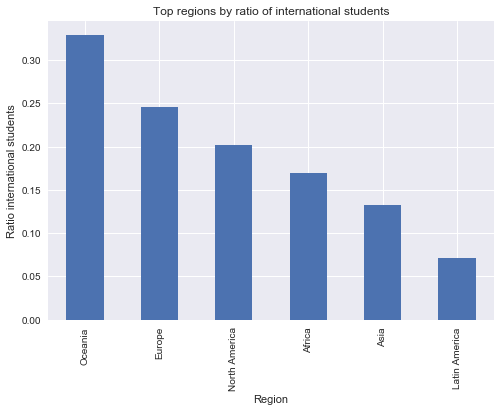

In [165]:
barplot = df_tu.groupby(region).mean().sort_values(international_students_ratio, ascending=False)\
    .plot.bar(y=international_students_ratio, legend=False)
barplot.set_title('Top regions by ratio of international students')
barplot.set_xlabel(region)
barplot.set_ylabel(international_students_ratio);

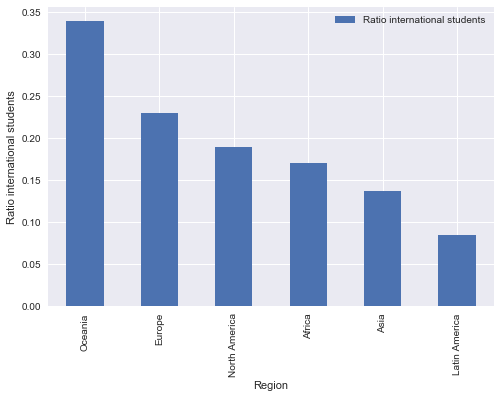

In [134]:
df_tu_QBD = sorted_ratio(df_tu_region, international_students, total_students, international_students_ratio).reset_index()
plot(df_tu_QBD, region, international_students_ratio, region, international_students_ratio)

## Question 2: Times Higher Education webpage

This time again, usin postman interceptor, we saw that the ranking was loaded from a json file. This time the json file contained all the data we needed, thus we took the first 200 universities and prepared the dataframe.

In [218]:
def prepare_uni_data_the(uni):
    uni_infos = dict()
    uni_infos['Name'] = map_name(normalize_name(uni['name']))
    uni_infos['Country'] = uni['location']
    uni_infos['Rank Time Higher Education'] = clean_number(uni['rank'])
    uni_infos['Number of Students'] = clean_number(uni['stats_number_students'])
    uni_infos['Student/Staff Ratio'] = clean_number(uni['stats_student_staff_ratio'])
    uni_infos['% of International Students'] = clean_number(uni['stats_pc_intl_students'])
    uni_infos[number_international_students] = uni_infos['% of International Students']/100*uni_infos['Number of Students']
    return uni_infos
res = get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json', 'html')
json_ranking_the = json.loads(res.text)['data']
json_ranking_the = sorted(json_ranking_the, key=lambda k: clean_number(k['rank']))[:200]
df_the = pd.DataFrame(list(map(prepare_uni_data_the,json_ranking_the)))

In [220]:
# df_the.to_pickle('df_the.xz')
df_the = pd.read_pickle('df_the.xz')

### Question a)
I sort the dataframe by using the values contained in the 'Student/Staff Ratio' column, assuming 'staff' is another name for 'faculty members'. 
What we are looking for is the 'Staff/student' Ratio, which can be visualized by sorting in ascending order according to the 'Student/Staff Ratio'.
The results are of course different compared to the respective ones in part 1, however US universities still dominate the board (7 out of 10).
#### Alternative
We assumed that 'staff' meant faculty number. The ratio we have is the reverse of what we want, thus we computed the ratio of faculty members/student by inversing the students/staff ratio.

We then sort by the ratio, take the top 10 and plot it.
The results are of course different compared to the ones in part 1, US universities still dominate the board (7 out of 10), however there is the appearance of some european universities. One possibility, is that most of these universities did not make it to the top 200 of the other ranking.

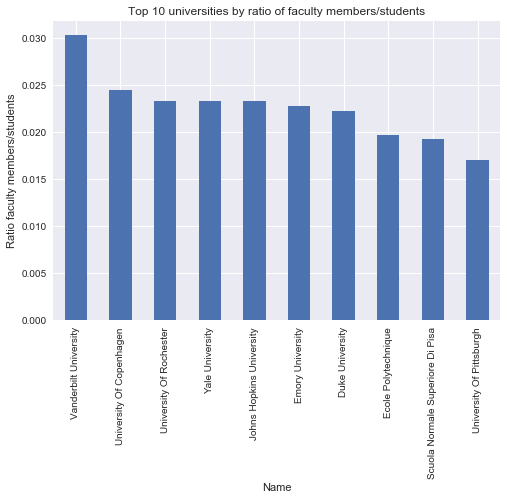

In [187]:
df_the[faculty_members_students_ratio] = 1.0/df_the[students_staff_ratio]

barplot = df_the.sort_values(by=faculty_members_students_ratio, ascending=False).iloc[:10]\
    .plot.bar(x=name, y=faculty_members_students_ratio, legend=False);
barplot.set_title('Top 10 universities by ratio of faculty members/students')
barplot.set_xlabel(name)
barplot.set_ylabel(faculty_members_students_ratio);

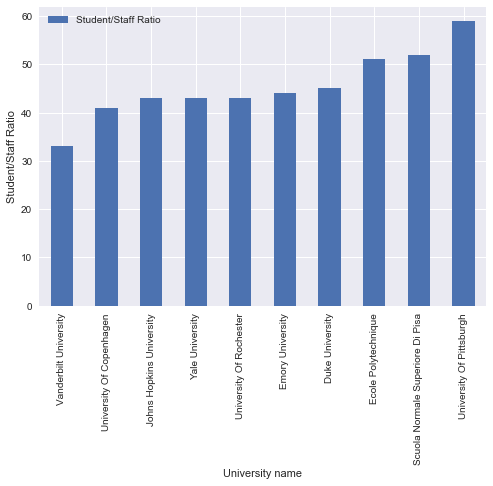

In [155]:
#NOTE! student/staff ratio value are multiplied x10 during the filtering, no difference for sorting.
#NOTE! ascending order in student/staff ratio == descending order in staff/student ratio
# and we're looking for staff/student ratio (assuming staff == faculty members)
df_the_QA = df_the.sort_values([students_staff_ratio], ascending=True)
reduced_plot(df_the_QA, name, students_staff_ratio, university_name, students_staff_ratio)

### Question b)
I sort the dataframe by using the values contained in the '% of international students" column.
The result are very similar to those of part 1: the same London universities as well as EPFL and Honk Kong university appears.

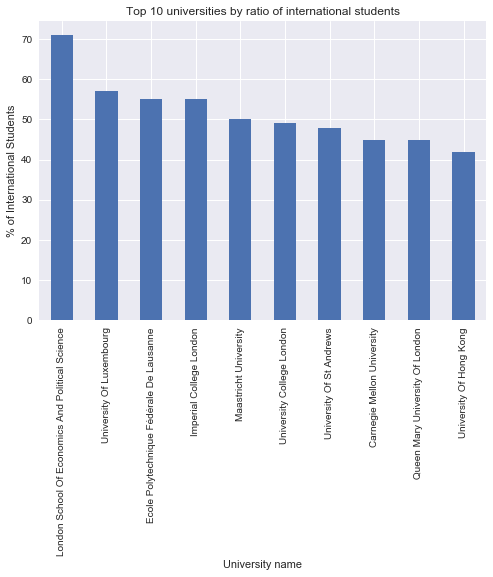

In [161]:
barplot = df_the.sort_values(by=pc_international_students, ascending=False).iloc[:10]\
    .plot.bar(x=name, y=pc_international_students, legend=False);
barplot.set_title('Top 10 universities by ratio of international students')
barplot.set_xlabel(university_name)
barplot.set_ylabel(pc_international_students);

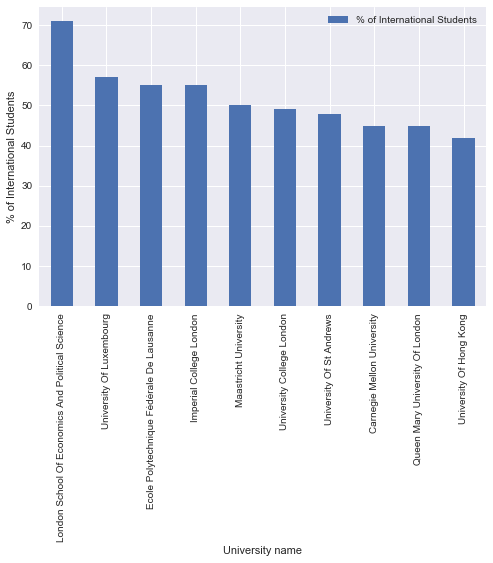

In [138]:
df_the_QB = df_the.sort_values([pc_international_students], ascending=False)
reduced_plot(df_the_QB, name, pc_international_students, university_name, pc_international_students)

## Question c)
### Faculty members and students ratio with country aggregation

The result is different but somehow consistent with part 1: Russia is still first place, while Japan, Taiwan, and Singapore for example are still high in the rankings.

#### Alternative
We group by country and compute the mean ratio, then we plot.

We have a similar results than previously, by looking at the score of some universities and the score of their country we see that they can either be representative of their country (e.g. Denmark, Italy) or it can be that the average in the country is high (e.g. Russia)

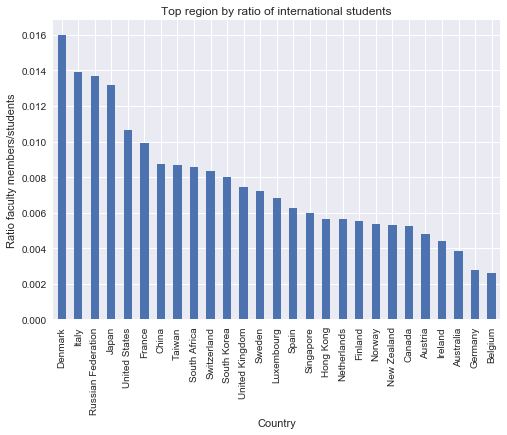

In [163]:
barplot = df_the.groupby(country).mean().sort_values(faculty_members_students_ratio, ascending=False)\
    .plot.bar(y=faculty_members_studentas_ratio, legend=False)
barplot.set_title('Top region by ratio of international students')
barplot.set_xlabel(country)
barplot.set_ylabel(faculty_members_students_ratio);

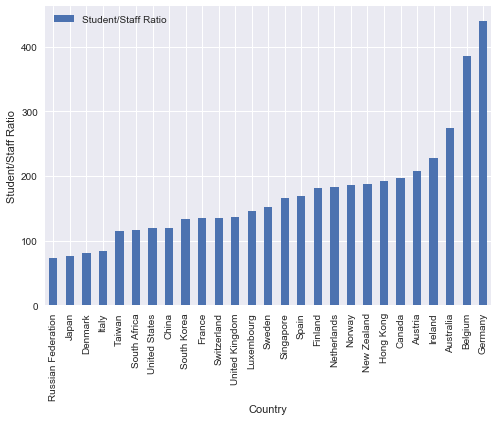

In [139]:
df_the_country = group(df_the, country)
df_the_QAC = df_the_country.sort_values([students_staff_ratio], ascending=True).reset_index()
plot(df_the_QAC, country, students_staff_ratio, country, students_staff_ratio)

### International students ratio with country aggregation

The result is coherent with question 2b) non-aggregated: US, UK and Switzerland are very high in the graduatory.
The main difference with part 1 is that here United States are high in the ranking, which gives an overall more coherent picture.

#### Alternative
Once again, we group by country and compute the mean ratio.

The ranking is very coherent with the ranking by universities, one can do a similar analysis than the one done before.

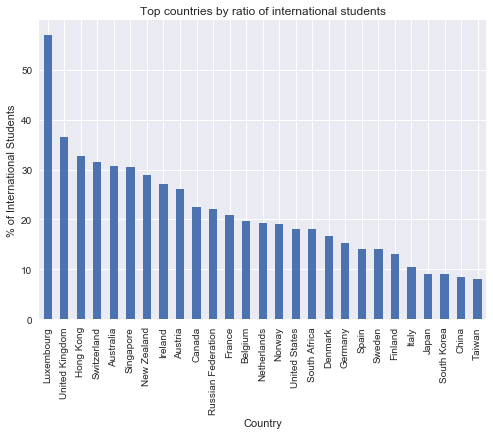

In [167]:
barplot = df_the.groupby(country).mean().sort_values(pc_international_students, ascending=False)\
    .plot.bar(y=pc_international_students, legend=False)
barplot.set_title('Top countries by ratio of international students')
barplot.set_xlabel(country)
barplot.set_ylabel(pc_international_students);

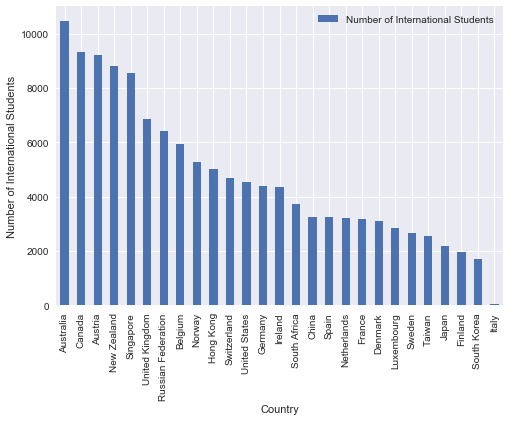

In [140]:
#NOTE i don't use math.ceil() on number of international students because i couldn't implement swiftly.
#less chanches of ties anyway
df_temp = df_the
df_temp[number_international_students] = df_temp[pc_international_students]*df_temp[number_students]/100
df_the_QBC = group(df_temp, country)
df_the_QBC = df_the_QBC.sort_values([number_international_students], ascending=False).reset_index()
plot(df_the_QBC, country, number_international_students, country, number_international_students)

In [179]:
# a method to map country to regions
def countryRegionMapping(df_to_map):
    df_with_mapping = df_tu[[country, region]].drop_duplicates()
    df_mapped = df_to_map.merge(df_with_mapping)
    return df_mapped

country_to_region = df_tu[[country,region]].drop_duplicates().set_index(country).to_dict()['Region']
df_the[region] = df_the[country].map(country_to_region)

## Question d)
### Faculty members and students ratio with region aggregation

The result is hard to explain. Apparently the ranking is reversed (Raph Albane ici aucune idée, faute peut-etre?)

#### Alternative
Once again, we group by region and compute the mean.

Bla bla

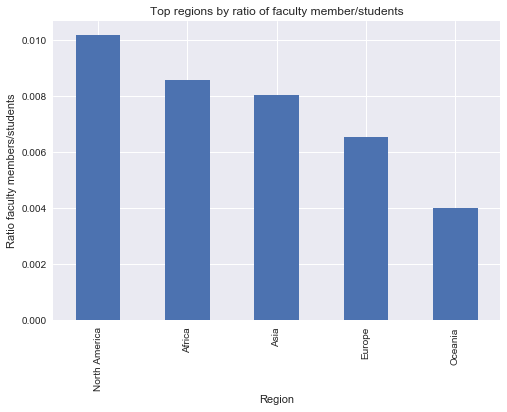

In [182]:
barplot = df_the.groupby(region).mean().sort_values(faculty_members_students_ratio, ascending=False)\
    .plot.bar(y=faculty_members_students_ratio, legend=False)
barplot.set_title('Top regions by ratio of faculty member/students')
barplot.set_xlabel(region)
barplot.set_ylabel(faculty_members_students_ratio);

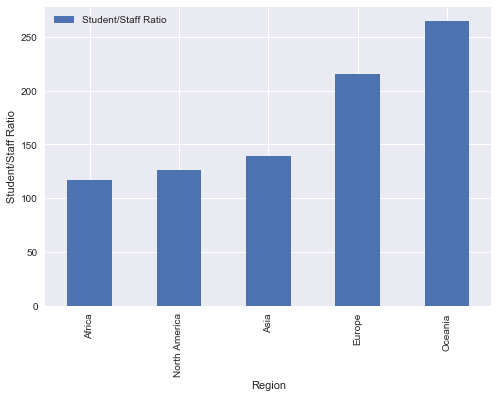

In [142]:
df_mapped = countryRegionMapping(df_the)
df_the_region = group(df_mapped, region)
df_the_QAD = df_the_region.sort_values([students_staff_ratio], ascending=True).reset_index()
plot(df_the_QAD, region, students_staff_ratio, region, students_staff_ratio)

### International students ratio with region aggregation

The result is coherent with all the previous ones, with European and North American universities at the top.

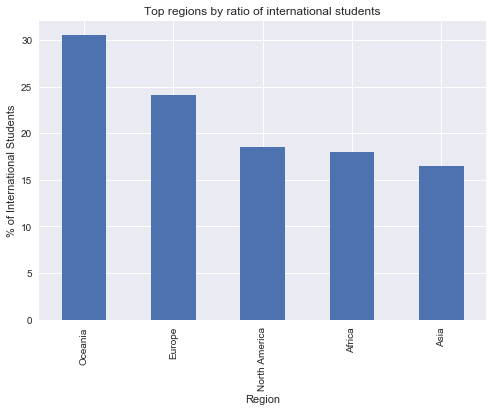

In [183]:
barplot = df_the.groupby(region).mean().sort_values(pc_international_students, ascending=False)\
    .plot.bar(y=pc_international_students, legend=False)
barplot.set_title('Top regions by ratio of international students')
barplot.set_xlabel(region)
barplot.set_ylabel(pc_international_students);

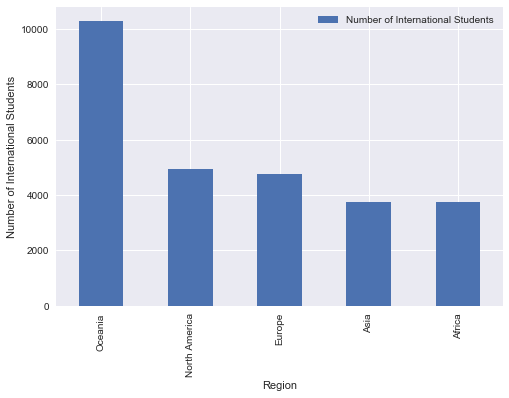

In [143]:
df_mapped = countryRegionMapping(df_temp)
df_the_QBD = group(df_mapped, region)
df_the_QBD = df_the_QBD.sort_values([number_international_students], ascending=False).reset_index()
plot(df_the_QBD, region, number_international_students, region, number_international_students)

# Question 3: dataframes merging

We decided to only take the intersection of the two top 200 of the rankings. We tried to match as many name as possible using the 'map_name' function above.

To make an intersection between the two dataframes, we do an inner join.

In [228]:
merged_df = df_tu.merge(df_the, 'inner', on=['Name'])

# Question 4: Exploratory analysis

We create two helpers functions to compute some correlations. We need those helper functions, because in some cases, the variables are not numbers, that is the case for countries for example. In order to be able to use these variables, we transform them into enumerated type or categorical variables, using the functions 'factorize'.

In [229]:
#converts variable type into int so it's possible to compute correlation
def factorize(df, variable):
    labels, uniques = pd.factorize(df[variable])
    df[variable] = labels
    
#computes correlation and convert variable type if necessary
def compute_correlation(x_variable, y_variable, x_needs_factorization = False, y_needs_factorization = False):
    correlation_df = merged_df[[x_variable, y_variable]]
    if x_needs_factorization:
        factorize(correlation_df, x_variable)
    if y_needs_factorization:
        factorize(correlation_df, y_variable)
    return correlation_df.corr().values[0][1]

In [230]:
#further column names
countryx = 'Country_x'
international_faculty_members = 'International faculty members'
rank_tu = 'Rank Top Universities'
rank_the = 'Rank Time Higher Education'

The correlation between country and number of international students for the topUniversites ranking (TU ranking) is very weak, which is kinda consistent with the fact that there are renowned university a bit everywhere.

In [231]:
#correlation country-number of international students for tu
compute_correlation(countryx, international_students, x_needs_factorization = True)

-0.16598074314729033

Same as above for the Times Higher Education ranking (THE ranking).

In [232]:
#correlation country-number of international students for the
compute_correlation(countryx, number_international_students, x_needs_factorization = True)

-0.20758239457858058

The value of the correlation in this case justifies the hypothesis of a moderate relationship between the number of international faculty members and number of international students. This makes sense: a university that is internationally recognized lures in both faculty members and students from abroad.

In [235]:
#correlation number of international faculty members - number of international students for tu
compute_correlation(international_faculty_members, international_students)

0.58051802475262637

The correlation between country and ranking for the TU ranking is weak, suggesting there's no linear relationship between the two variables

In [236]:
#correlation country-ranking for tu
compute_correlation(countryx, rank_tu, x_needs_factorization = True)

0.35325266087653112

The correlation between country and ranking for the THE ranking website suggests a moderate linear relationship.

In [237]:
#correlation country-ranking for the
compute_correlation(countryx, rank_the, x_needs_factorization = True)

0.44049236971783623

the correlation between ranking and region is close to 0 for TU ranking. No linear relationship.

In [239]:
#correlation region-ranking for tu
compute_correlation(region, rank_tu, x_needs_factorization = True)

-0.059616902632494792

the correlation between ranking and region is much higher for THE, which is consistent with the higher ranking-country correlation.

In [240]:
#correlation region-ranking for the
compute_correlation(region, rank_the, x_needs_factorization = True)

0.31861024508211183

There's a tangible linear relationship between number of faculty members and number of students, which might be given by how big a university is: the bigger it is, the more students and faculty members it has.

In [241]:
#correlation total faculty members - total students for tu
compute_correlation(total_faculty_members, total_students)
#kinda high correlation - makes sense

0.58846097194166191

There's a strong correlation between the TU and THE ranking, which makes sense since the ranking process should be a very objective one, and therefore both websites should rank universities in a similar way.

In [242]:
#correlation rank in first website - rank in second website
compute_correlation(rank_tu, rank_the)
# very high correlation thanks god - makes sense

0.69114609667868976

# Question 5: best university

In [243]:
#further column names
mean_rank = 'mean rank'

simply take the average of the two ranking associated to each university. The result is overall consistent with the previous ones: renowned American and English university are at the top of the ranking, plus ETHZ.

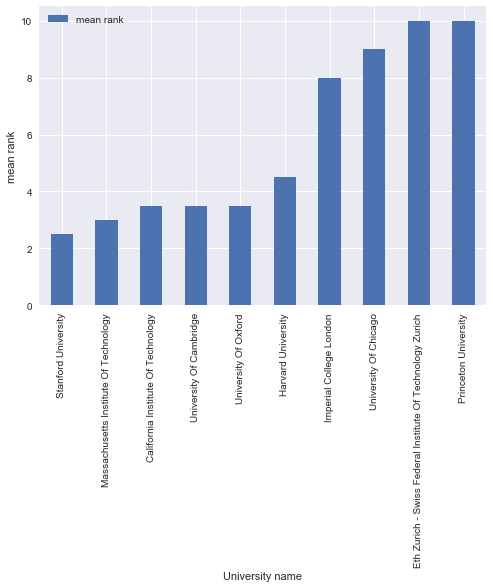

In [244]:
filtered_merged_df[mean_rank] = (filtered_merged_df[rank_tu]+filtered_merged_df[rank_the])/2
mean_ranking_df = filtered_merged_df.sort_values(by=[mean_rank], ascending=True)
reduced_plot(mean_ranking_df, name, mean_rank, university_name, mean_rank)